In [3]:
import psycopg2
import gensim
import faiss
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from adjustText import adjust_text
import pandas as pd
from faiss import write_index

plt.rcParams["figure.figsize"] = [10, 6]

# Traer los posts de la base de datos

In [4]:
connection = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="127.0.0.1",
    port="63333",
    database="stack_overflow",
)

In [5]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """select p.id, p.title, p.body_text
        from posts_19 p
        join posts_19_tags pt on pt.post_id=p.id
        join tags t on pt.tag_id=t.id
        where p.body_text is not null
        and p.post_type_id=1 
        and creation_date < '2022-01-01'
        and t.tag_name = 'python'
        limit 50000"""
        )
        posts = cursor.fetchall()

In [32]:
posts[:3]

[(464040,
  'How are POST and GET variables handled in Python?',
  "In PHP you can just use $_POST for POST and $_GET for GET (Query string) variables. What's the equivalent in Python?\n"),
 (464342,
  'Combining two sorted lists in Python',
  'I have two lists of objects. Each list is already sorted by a property of the object that is of the datetime type. I would like to combine the two lists into one sorted list. Is the best way just to do a sort or is there a smarter way to do this in Python?\n'),
 (464864,
  'How to get all possible combinations of a list’s elements?',
  "I have a list with 15 numbers, and I need to write some code that produces all 32,768 combinations of those numbers.\nI've found some code (by Googling) that apparently does what I'm looking for, but I found the code fairly opaque and am wary of using it. Plus I have a feeling there must be a more elegant solution.\nThe only thing that occurs to me would be to just loop through the decimal integers 1–32768 and co

In [6]:
post2idx = {p_id: idx for idx, (p_id, _, _) in enumerate(posts)}

In [7]:
t_posts = []
for p_id, title, body in posts:
    post_text = body
    if title is not None:
        post_text = title + "\n\n" + body
    tokens = gensim.utils.simple_preprocess(post_text)
    # Use string due to int management in doc2vec
    # https://stackoverflow.com/questions/43051902/gensim-docvecs-most-similar-returns-ids-that-dont-exist
    t_posts.append(gensim.models.doc2vec.TaggedDocument(tokens, [str(p_id)]))

# Entrenar el doc2vec

In [36]:
model = gensim.models.doc2vec.Doc2Vec(
    t_posts, vector_size=20, epochs=50, hs=1, min_count=20, workers=8
)

In [37]:
model.save("model.doc")

In [38]:
posts[3]

(465348,
 'How can I overwrite/print over the current line in Windows command line?',
 "On Unix, I can either use \\r (carriage return) or \\b (backspace) to overwrite the current line (print over text already visible) in the shell.\nCan I achieve the same effect in a Windows command line from a Python script?\nI tried the curses module but it doesn't seem to be available on Windows.\n")

In [44]:
model.infer_vector(t_posts[3].words)

array([ 4.555856  , -0.03371684,  0.1680721 ,  2.460186  , -0.4023263 ,
       -2.726442  , -0.98851573,  2.6198325 ,  2.7738237 , -0.7877057 ,
       -0.05269584,  0.08494169, -1.2083099 , -1.7774223 , -2.7967176 ,
        1.6689178 ,  1.9527009 , -1.2089049 , -1.8906035 , -3.3286183 ],
      dtype=float32)

# Traer vecinos cercanos con doc2vec

In [51]:
post0_vector = model.infer_vector(t_posts[3].words)
ids_sim = model.dv.most_similar([post0_vector], topn=3)
print(f"similarity: {ids_sim[0][1]}, for doc id: {ids_sim[0][0]}")
for p_id, sim in ids_sim[1:]:
    print(f"similarity: {sim}, for doc: {posts[post2idx[int(p_id)]][2]}")

similarity: 0.9804398417472839, for doc id: 465348
similarity: 0.8809648752212524, for doc: Let's say I have a python program that is spitting out lines of text, such as:
while 1:
  print "This is a line"

What's the easiest way to allow one to press a key on the keyboard to pause the loop, then to resume if pressed again---but if nothing is pressed it should just continue on automatically?
I'm hoping I don't have to go into something like curses to get this!

similarity: 0.8738726377487183, for doc: All my python scripts work just fine when I run them in Eclipse, however when I drage them over to the python.exe, they never work, the cmd opens and closes immediately. If I try to do it with a command in cmd, so it doesn't close, I get errors like:
ImportErrror: No module named Some Name
and the likes.
How can I resolve this issue?



# Traer vecinos cercanos con faiss

In [52]:
p_vectors_ids = [(model.infer_vector(p.words), p.tags[0]) for p in t_posts]

In [53]:
vectors, vectors_ids = zip(*p_vectors_ids)
vectors = np.array(vectors)
vectors_ids = np.array(vectors_ids)

In [55]:
index = faiss.index_factory(20, "IDMap,Flat")
index.train(vectors)
index.add_with_ids(vectors, vectors_ids)

In [56]:
distances, neighbors = index.search(post0_vector.reshape(1, -1), 3)

for p_id, dist in zip(neighbors[0], distances[0]):
    print(f"distance: {dist}, for doc: {posts[post2idx[int(p_id)]][2]}")

distance: 0.25376176834106445, for doc: On Unix, I can either use \r (carriage return) or \b (backspace) to overwrite the current line (print over text already visible) in the shell.
Can I achieve the same effect in a Windows command line from a Python script?
I tried the curses module but it doesn't seem to be available on Windows.

distance: 24.466320037841797, for doc: Let's say I have a python program that is spitting out lines of text, such as:
while 1:
  print "This is a line"

What's the easiest way to allow one to press a key on the keyboard to pause the loop, then to resume if pressed again---but if nothing is pressed it should just continue on automatically?
I'm hoping I don't have to go into something like curses to get this!

distance: 24.54994010925293, for doc: All my python scripts work just fine when I run them in Eclipse, however when I drage them over to the python.exe, they never work, the cmd opens and closes immediately. If I try to do it with a command in cmd, so 

In [57]:
write_index(index, "doc2vec.index")

# Posts TSNE

In [58]:
X_embedded = TSNE(n_components=2, init="random", perplexity=80).fit_transform(vectors)

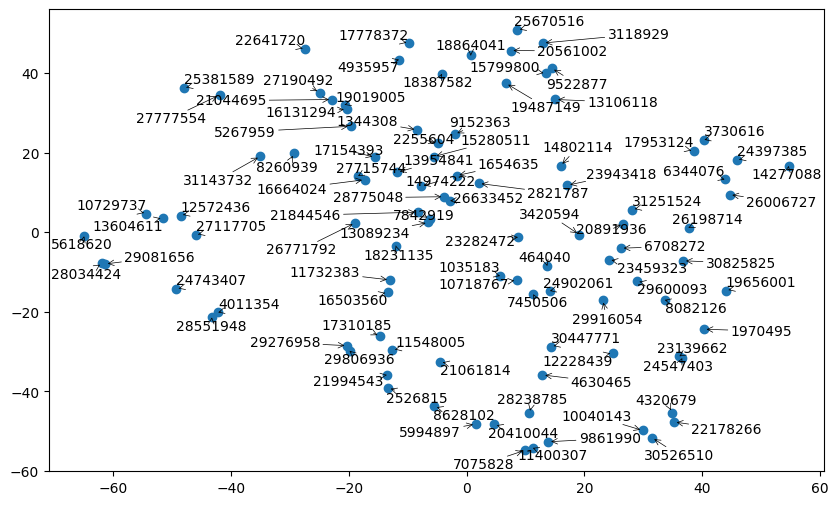

In [65]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[::500, 0], X_embedded[::500, 1])

texts = []
for i, p_id in enumerate(vectors_ids[::500]):
    texts.append(ax.text(X_embedded[i * 500, 0], X_embedded[i * 500, 1], p_id))
adjust_text(
    texts,
    only_move={"points": "y", "texts": "y"},
    arrowprops=dict(arrowstyle="->", color="black", lw=0.5),
);

In [80]:
print(posts[post2idx[4011354]][2])

Is it possible to create a multi-line label with word wrap that resizes in sync with the width of its parent? In other words the wordwrap behavior of Notepad as you change the width of the NotePad window.
The use case is a dialog that needs to present a block of multi-line text (instructions) in its entirety without having the text clipped or resorting to scrollbars. The parent container will have enough vertical space to accomodate narrow widths.
I've been experimenting with Tkinter Label and Message widgets and the ttk Label widget without success. It seems that I need to hard code a pixel wraplength value vs. have these controls auto wordwrap when their text reaches the right edge of their containers. Certainly Tkinters geometry managers can help me auto-resize my labels and update their wraplength values accordingly?
Should I be looking at the Text widget instead? If so, is it possible to hide the border of a Text widget so I can use it as a multi-line label with wordwrap?
Here's a

In [81]:
print(posts[post2idx[28551948]][2])

I know that Tkinter is not so modern, not so cool and maybe better to use PyQt or etc.
But it is interesting for me can Tkinter look not so ugly in Ubuntu (Linux). Looks that brew version (in OS X) of python's Tkinter compiled with built-in theme and looks good:

But Ubuntu's Tkinter makes me cry:

I've read that for good theme I need to use ttk, but I dont know exactly how. My code looks as follow:
from Tkinter import *

class App():
  def __init__(self, master):
    frame = Frame(master)
    frame.pack()

    master.title("Just my example")
    self.label = Label(frame, text="Type very long text:")

    self.entry = Entry(frame)

    self.button = Button(frame,
                         text="Quit", fg="red", width=20,
                         command=frame.quit)


    self.slogan = Button(frame,
                         text="Hello", width=20,
                         command=self.write_slogan)

    self.label.grid(row=0, column=0)
    self.entry.grid(row=0, column=1)
    self.slogan

In [82]:
print(posts[post2idx[25670516]][2])

I'm trying to create a dict containing several lambda functions. The lambda functions are numpy percentile functions. However I get strange results, as if all lambda functions contain np.percentile(x,q=100).
import numpy as np

d = {}
inc = 10

for i in range(0,101,inc):
    d[str(i)+'_perc'] = lambda x: np.percentile(x,q=i)

a = [1,2,3,4,5]

print(d)
print(d['10_perc'](a))
print(d['50_perc'](a))
print(d['90_perc'](a))

Printing produces:
{'50_perc': <function <lambda> at 0x2cb7b90>, '70_perc': <function <lambda> at 0x2cb77d0>, '40_perc': <function <lambda> at 0x2cb75f0>, '10_perc': <function <lambda> at 0x2cb7cf8>, '30_perc': <function <lambda> at 0x2cb7500>, '0_perc': <function <lambda> at 0x2cb7aa0>, '80_perc': <function <lambda> at 0x2cb78c0>, '20_perc': <function <lambda> at 0x2cb7a28>, '100_perc': <function <lambda> at 0x2cb7848>, '90_perc': <function <lambda> at 0x2cb7758>, '60_perc': <function <lambda> at 0x2cb7d70>}
5
5
5

As if all lambda functions were overwritten by the sub

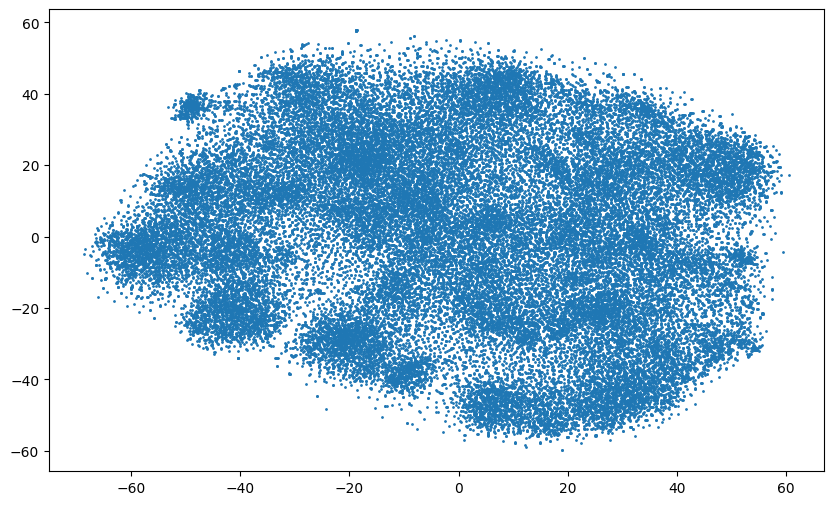

In [79]:
fig, ax = plt.subplots()
ax.scatter(X_embedded[::, 0], X_embedded[::, 1], s=1)

# TSNE por pais

In [101]:
with connection:
    with connection.cursor() as cursor:
        cursor.execute(
            """select u.country, p.id
        from posts_19 p
        join users u on p.owner_user_id=u.id
        where u.country is not null and p.post_type_id=1
        and p.id in %s""",
            [tuple(post2idx.keys())],
        )
        countries = pd.DataFrame(cursor.fetchall(), columns=["country", "qid"])

In [99]:
X_embedded[[0, 2, 4], 1], X_embedded[:5:2, 1]

(array([ -8.507225,  19.916887, -36.509483], dtype=float32),
 array([ -8.507225,  19.916887, -36.509483], dtype=float32))

In [116]:
top_countries = countries["country"].value_counts().index[:3]
countries["country"].value_counts()[:6]

United States     5610
United Kingdom    1773
India             1585
Canada            1270
Germany           1148
Australia          787
Name: country, dtype: int64

In [117]:
countries["idx"] = countries["qid"].apply(lambda x: post2idx[x])

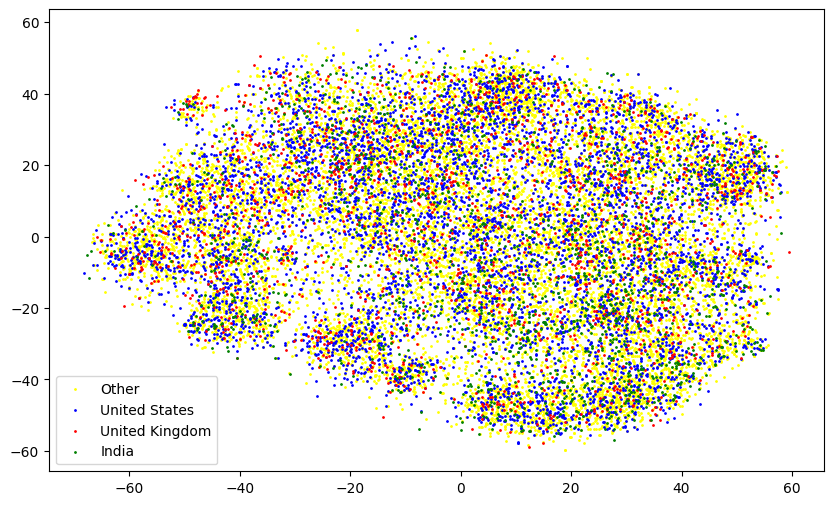

In [125]:
fig, ax = plt.subplots()
idxes = countries[~countries["country"].isin(top_countries)]["idx"].values
ax.scatter(
    X_embedded[idxes, 0], X_embedded[idxes, 1], s=1, label="Other", color="yellow"
)
for country, color in zip(top_countries, ["blue", "red", "green"]):
    idxes = countries[countries["country"] == country]["idx"].values
    ax.scatter(
        X_embedded[idxes, 0], X_embedded[idxes, 1], s=1, label=country, color=color
    )

plt.legend()